# Diagramatic Approach

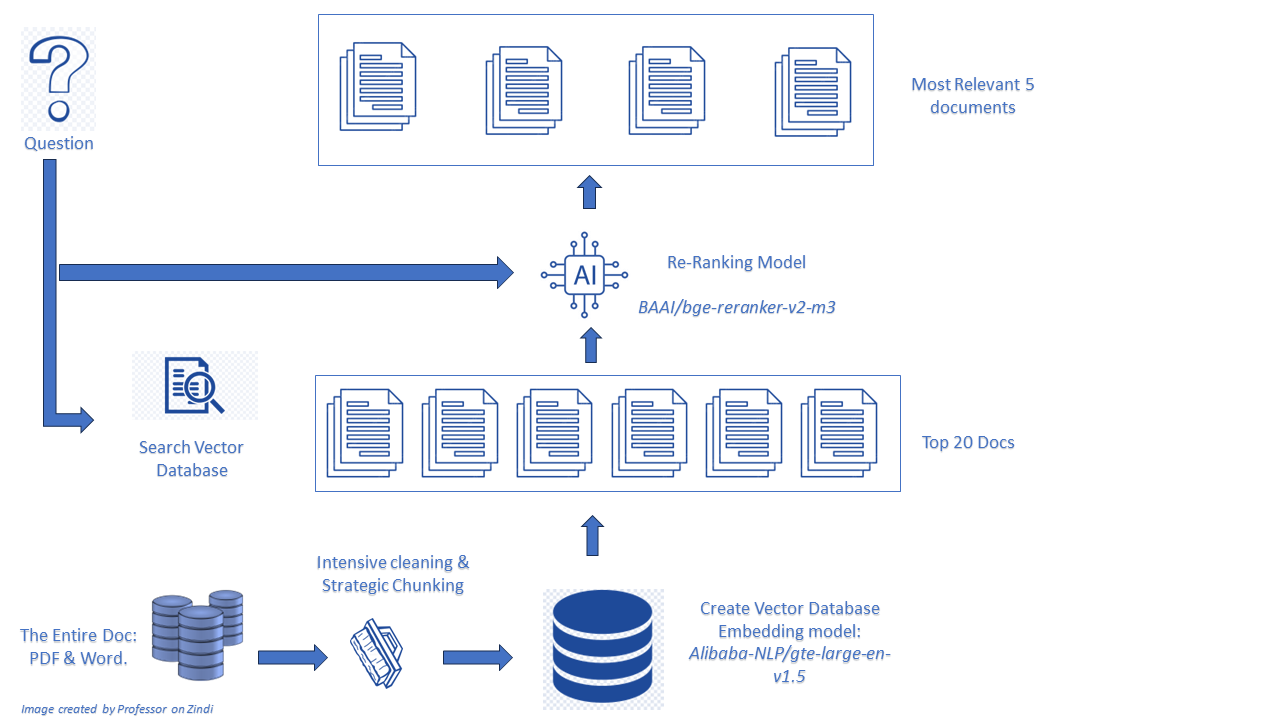

###### Coding

In [1]:
import pandas as pd
test = pd.read_csv("/kaggle/input/rag-documents/Test.csv")
test.head()

,Query No,Query text,Document No,Document Title,Output_1,Output_2,Output_3,Output_4,Output_5
0,1,Can the Conference of the Parties of the WHO F...,1,1_WHO_FCTC,NaN,NaN,NaN,NaN,NaN
1,2,What should be the minimum size of health warn...,1,1_WHO_FCTC,NaN,NaN,NaN,NaN,NaN
2,3,I opened a company to produce sensors in Kuala...,2,2_SalesTaxAct2018_Malaysia,NaN,NaN,NaN,NaN,NaN
3,4,I opened a company to produce sensors in Kuala...,2,2_SalesTaxAct2018_Malaysia,NaN,NaN,NaN,NaN,NaN
4,5,What specific indicators and targets are outli...,3,3_Canada_Cybersec_Strategy,NaN,NaN,NaN,NaN,NaN


import torch

In [2]:
%%capture
!pip install transformers accelerate xformers sentence_transformers chromadb

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import shutil

all_files = os.listdir("/kaggle/input/rag-documents/Test Documents")

In [5]:
%%capture

!pip install langchain langchain-community -qq

In [6]:
%pip install --upgrade --quiet  docx2txt

Note: you may need to restart the kernel to use updated packages.


In [7]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
from langchain.document_loaders import PyPDFLoader, Docx2txtLoader
import shutil
from tqdm import tqdm

In [8]:
all_files_pdf = [i for i in all_files if i.endswith(".pdf")]
all_files_pdf

['2_SalesTaxAct2018_Malaysia.pdf',
 '1_WHO_FCTC.pdf',
 '3_Canada_Cybersec_Strategy.pdf',
 '5_CyberPeace_Report.pdf']

In [9]:
all_files_docx = [i for i in all_files if i.endswith(".docx")]
all_files_docx

['4_GovStack_Specs.docx']

In [10]:
loaders_pdf  =  [PyPDFLoader(f"/kaggle/input/rag-documents/Test Documents/{i}") for i in all_files_pdf]
loaders_docx =  [Docx2txtLoader(f"/kaggle/input/rag-documents/Test Documents/{i}") for i in all_files_docx]

In [11]:
docs = []
for loader in loaders_pdf:
    docs.extend(loader.load())
    
for loader in loaders_docx:
    docs.extend(loader.load())

In [12]:
import torch

model_name = "Alibaba-NLP/gte-large-en-v1.5"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_kwargs = {"device": device, "trust_remote_code": True}


embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/57.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [13]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-reranker-v2-m3')
model = AutoModelForSequenceClassification.from_pretrained('BAAI/bge-reranker-v2-m3')

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

In [14]:
import re
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

def clean_text(text):
    # Remove non-English characters (retain basic punctuation)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # Remove excessive ellipses
    text = re.sub(r'\.{3,}', '...', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Concatenate the text content of the pages
combined_text = " ".join(doc.page_content for doc in docs)

# Clean the combined text
cleaned_text = clean_text(combined_text)

# Define the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=300,
    separators=['\n\n', '\n', '.', '!', '?', ',', ' ', '']
)

# Split the cleaned text into chunks
chunks = text_splitter.split_text(cleaned_text)

# Create new Document objects for each chunk with metadata from the original documents
splits = []
for i, chunk in enumerate(chunks):
    splits.append(
        Document(page_content=chunk, metadata={'source': docs[0].metadata['source'], 'chunk': i})
    )

In [15]:
persist_directory = "docs/chroma/"

# Specify the path of the directory to be removed
directory_path = "docs/"

# Remove the directory and its contents
shutil.rmtree(directory_path, ignore_errors=True)


# Create Chroma vector database
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory)

In [16]:
# Iterate through the rows of the DataFrame

for idx, row in test.iterrows():
    question = row["Query text"].lower()
    
    # Perform a similarity search to get the top 20 documents
    docs = vectordb.similarity_search(question, k=20)
    
    # Create pairs of question and document content
    pairs = [[question, docs[i].page_content] for i in range(len(docs))]
    
    # Tokenize the pairs
    with torch.no_grad():
        inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
        # Get the scores from the model
        scores = model(**inputs, return_dict=True).logits.view(-1, ).float()
        
    # Sort indices of scores in descending order
    sorted_indices = torch.argsort(scores, descending=True)
    
    # Rearrange docs based on sorted indices
    sorted_docs = [docs[i] for i in sorted_indices]
    
    # Get the top 5 document chunks
    top_5_chunks = [sorted_docs[i].page_content for i in range(min(5, len(sorted_docs)))]
    
    # Fill in the DataFrame columns
    for i in range(5):
        column_name = f"Output_{i+1}"
        if i < len(top_5_chunks):
            test.at[idx, column_name] = top_5_chunks[i]
        else:
            test.at[idx, column_name] = None  # If less than 5 chunks are available, fill with None

In [17]:
test.to_csv("results.csv", index=False)

In [18]:
print(test.iloc[0]["Output_1"])

. 5. The Parties agree that: (a) to assist Parties in meeting their obligations under the Convention, all relevant potential and existing resources, financial, technical, or otherwise, both public and private that are available for tobacco control activities, should be mobilized and utilized for the benefit of all Parties, especially d e v e l o p i n g c o u n t r i e s a n d c o u n t r i e s w i t h economies in transition; (b) the Secretariat shall advise develo ping country Parties and Parties with economies in transition, upon request, on available sources of funding to facilitate the implementation of their obligations under the Convention; (c) the Conference of the Parties in its first session shall review existing and potential sources and mechanisms of assistance based on a study conducted by the Secretariat and other relevant informat ion, and consider their adequacy; and (d) the results of this review shall be taken into account by the Conference of the Parties in determini

In [19]:
test

,Query No,Query text,Document No,Document Title,Output_1,Output_2,Output_3,Output_4,Output_5
0,1,Can the Conference of the Parties of the WHO F...,1,1_WHO_FCTC,. 5. The Parties agree that: (a) to assist Par...,. Article 21 Reporting and exchange of informa...,. Article 25 Relations between the Conference ...,. 5. The Conference of the Parties shall keep ...,. 2. The Conference of the Parties shall prom ...
1,2,What should be the minimum size of health warn...,1,1_WHO_FCTC,. These warnings and messages: (i) shall be ap...,. 3. A Party that is not in a position to unde...,". Each Party shall, where approved by competen...",. Special emphasis shall be placed on cooperat...,. 3. Each Party shall require that the pack ag...
2,3,I opened a company to produce sensors in Kuala...,2,2_SalesTaxAct2018_Malaysia,", namely Rusukan Besar, Rusukan Kecil, Keraman...",Sales Tax 1 LAWS O F M A L A Y S I A Act 806 S...,. PART X I I I SA VINGS AND TRANSITIONAL Regis...,. (3) Where the taxable goods referred to in s...,. (3) Where the Director General is satisfied ...
3,4,I opened a company to produce sensors in Kuala...,2,2_SalesTaxAct2018_Malaysia,. (4) Where a registered manufacturer sold any...,. (2) In relation to a company that is being w...,. Rate of sales tax 10. (1) Sales tax shall be...,. (2) This section shall not apply to petroleu...,. Repayment of sales tax in relation to bad de...
4,5,What specific indicators and targets are outli...,3,3_Canada_Cybersec_Strategy,. This includes ongoing and future efforts to ...,". Informed by over 2,000 submissions to our pu...",. Responding to calls for decisive federal lea...,". Together, we will explore initiatives to ens...",. There is no security without privacy. And li...
5,6,What measures is the government of Canada taki...,3,3_Canada_Cybersec_Strategy,. From individuals that use few technologies t...,". Individuals, governments, and businesses all...",. This includes ongoing and future efforts to ...,. In response to cyber threats of increasing s...,. Responding to calls for decisive federal lea...
6,7,What are the API requirements that apply to th...,4,4_GovStack_Specs,. 5.2 Exceptions to Architectural Cross-Cuttin...,.) 4.2 Any Consent Fundamental individual righ...,. Workflow Building Block is especially inappr...,. The term and definition is inspired by Lessi...,. External APIs are described using the OpenAP...
7,8,What additional building blocks are essential ...,4,4_GovStack_Specs,. The term and definition is inspired by Lessi...,. The Consent process (creating and signing Co...,. Building blocks should be designed to suppor...,. The main Administrator actions expected to p...,. Interactions with other Building Blocks The ...
8,9,What are the key findings of the CyberPeace In...,5,5_CyberPeace_Report,. They have been shared with the NGOs who part...,. 14 CyberPeace Analytical ReportNGOs should f...,". Together, these NGOs bring vital aid and ser...",. The sample size of 27 NGOs allowed for a det...,. Although the focus of the current report is ...
9,10,What are the key lessons learnt from the case ...,5,5_CyberPeace_Report,. 5. Lessons Learned Some of the key lessons l...,. Ransom payments The NCSC recommends that org...,.9 of NGOs consider social engineering to be a...,. Implement continuous website monitoring to d...,. 4. Impact This MitM attack had several signi...


In [20]:
df = test.copy()

import pandas as pd
import nltk
nltk.download('punkt')  # Ensure you have the necessary NLTK data

# Function to count tokens in a text
def count_tokens(text):
    tokens = nltk.word_tokenize(text)
    return len(tokens)

# Apply the function to each column and create new columns for token counts
for col in ['Output_1', 'Output_2', 'Output_3', 'Output_4', 'Output_5']:
    df[col + '_token_count'] = df[col].apply(count_tokens)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
df

,Query No,Query text,Document No,Document Title,Output_1,Output_2,Output_3,Output_4,Output_5,Output_1_token_count,Output_2_token_count,Output_3_token_count,Output_4_token_count,Output_5_token_count
0,1,Can the Conference of the Parties of the WHO F...,1,1_WHO_FCTC,. 5. The Parties agree that: (a) to assist Par...,. Article 21 Reporting and exchange of informa...,. Article 25 Relations between the Conference ...,. 5. The Conference of the Parties shall keep ...,. 2. The Conference of the Parties shall prom ...,354,392,254,350,303
1,2,What should be the minimum size of health warn...,1,1_WHO_FCTC,. These warnings and messages: (i) shall be ap...,. 3. A Party that is not in a position to unde...,". Each Party shall, where approved by competen...",. Special emphasis shall be placed on cooperat...,. 3. Each Party shall require that the pack ag...,371,259,301,374,332
2,3,I opened a company to produce sensors in Kuala...,2,2_SalesTaxAct2018_Malaysia,", namely Rusukan Besar, Rusukan Kecil, Keraman...",Sales Tax 1 LAWS O F M A L A Y S I A Act 806 S...,. PART X I I I SA VINGS AND TRANSITIONAL Regis...,. (3) Where the taxable goods referred to in s...,. (3) Where the Director General is satisfied ...,365,387,324,316,351
3,4,I opened a company to produce sensors in Kuala...,2,2_SalesTaxAct2018_Malaysia,. (4) Where a registered manufacturer sold any...,. (2) In relation to a company that is being w...,. Rate of sales tax 10. (1) Sales tax shall be...,. (2) This section shall not apply to petroleu...,. Repayment of sales tax in relation to bad de...,338,378,426,390,414
4,5,What specific indicators and targets are outli...,3,3_Canada_Cybersec_Strategy,. This includes ongoing and future efforts to ...,". Informed by over 2,000 submissions to our pu...",. Responding to calls for decisive federal lea...,". Together, we will explore initiatives to ens...",. There is no security without privacy. And li...,313,320,314,321,280
5,6,What measures is the government of Canada taki...,3,3_Canada_Cybersec_Strategy,. From individuals that use few technologies t...,". Individuals, governments, and businesses all...",. This includes ongoing and future efforts to ...,. In response to cyber threats of increasing s...,. Responding to calls for decisive federal lea...,310,304,313,295,314
6,7,What are the API requirements that apply to th...,4,4_GovStack_Specs,. 5.2 Exceptions to Architectural Cross-Cuttin...,.) 4.2 Any Consent Fundamental individual righ...,. Workflow Building Block is especially inappr...,. The term and definition is inspired by Lessi...,. External APIs are described using the OpenAP...,171,298,288,302,309
7,8,What additional building blocks are essential ...,4,4_GovStack_Specs,. The term and definition is inspired by Lessi...,. The Consent process (creating and signing Co...,. Building blocks should be designed to suppor...,. The main Administrator actions expected to p...,. Interactions with other Building Blocks The ...,302,272,301,294,307
8,9,What are the key findings of the CyberPeace In...,5,5_CyberPeace_Report,. They have been shared with the NGOs who part...,. 14 CyberPeace Analytical ReportNGOs should f...,". Together, these NGOs bring vital aid and ser...",. The sample size of 27 NGOs allowed for a det...,. Although the focus of the current report is ...,301,303,327,297,285
9,10,What are the key lessons learnt from the case ...,5,5_CyberPeace_Report,. 5. Lessons Learned Some of the key lessons l...,. Ransom payments The NCSC recommends that org...,.9 of NGOs consider social engineering to be a...,. Implement continuous website monitoring to d...,. 4. Impact This MitM attack had several signi...,311,318,339,305,309
